In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report


random_state = 27

In [2]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(f'data/{category}'): #path to the folders with data
            img = cv2.imread(f'data/{category}/{image_name}') #path to the folders
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

            img_array = cv2.resize(img, (150,150)) 

            img_lst.append(img_array)
            labels.append(index)
    return img_lst, labels

categories = ['disco', 'electro', 'folk', 'rap', 'rock'] 

img_lst, labels = load_images_and_labels(categories)

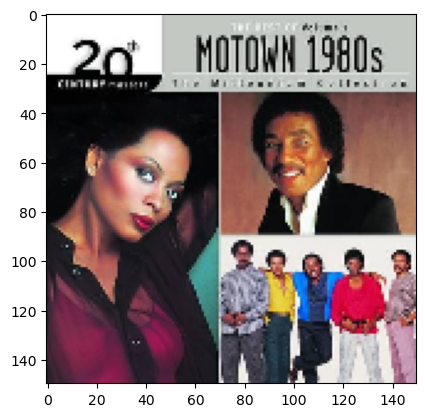

In [3]:
plt.imshow(img_lst[27])
plt.show()

In [4]:
images = np.array(img_lst) / 255.0 #normalization
labels = to_categorical(labels)  #one hot encoding


In [5]:
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_state)


In [7]:
print("x_train shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)


print("x_test shape: ", x_test.shape)
print("y_test.shape: ", y_test.shape)

print("x_test shape: ", x_val.shape)
print("y_test.shape: ", y_val.shape)

x_train shape:  (4468, 150, 150, 3)
y_train.shape:  (4468, 5)
x_test shape:  (3725, 150, 150, 3)
y_test.shape:  (3725, 5)
x_test shape:  (1118, 150, 150, 3)
y_test.shape:  (1118, 5)


In [9]:
from tensorflow.keras.applications import DenseNet121
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

baseModel = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in baseModel.layers:
    layer.trainable = False

# Create the top layers that will be trained
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.1)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(5, activation="softmax")(headModel)

# Put together the base model with the new layers
model = Model(inputs=baseModel.input, outputs=headModel)

# Compile the model with Adam optimizer
optimizer = Adam(lr=0.00001, decay=0.0001 / 20)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_val, y_val), callbacks= [early_stopping])


Epoch 1/100
70/70 [==============================] - 93s 1s/step - loss: 1.6537 - accuracy: 0.2088 - val_loss: 1.6161 - val_accuracy: 0.2165
Epoch 2/100
70/70 [==============================] - 80s 1s/step - loss: 1.6034 - accuracy: 0.2379 - val_loss: 1.6025 - val_accuracy: 0.2451
Epoch 3/100
70/70 [==============================] - 76s 1s/step - loss: 1.5827 - accuracy: 0.2583 - val_loss: 1.5900 - val_accuracy: 0.2558
Epoch 4/100
70/70 [==============================] - 76s 1s/step - loss: 1.5634 - accuracy: 0.2833 - val_loss: 1.5775 - val_accuracy: 0.2576
Epoch 5/100
70/70 [==============================] - 79s 1s/step - loss: 1.5472 - accuracy: 0.2972 - val_loss: 1.5649 - val_accuracy: 0.2809
Epoch 6/100
70/70 [==============================] - 78s 1s/step - loss: 1.5241 - accuracy: 0.3189 - val_loss: 1.5528 - val_accuracy: 0.2943
Epoch 7/100
70/70 [==============================] - 77s 1s/step - loss: 1.5053 - accuracy: 0.3353 - val_loss: 1.5408 - val_accuracy: 0.3086
Epoch 8/100
7

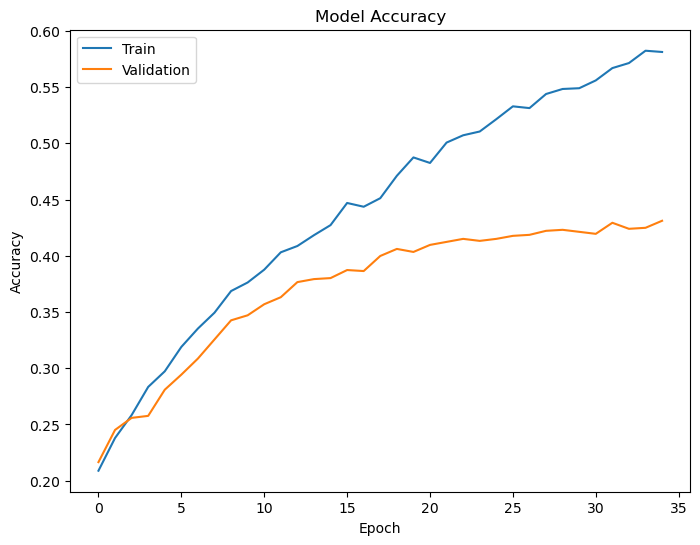

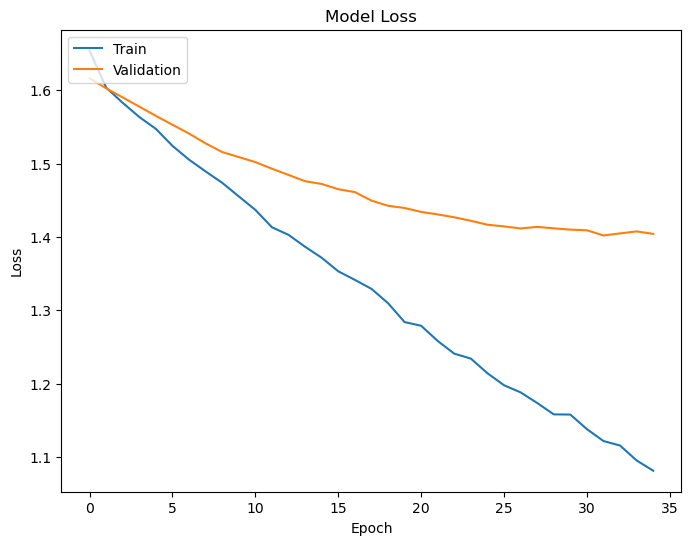

In [10]:
# summarize history for accuracy
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [11]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

117/117 [==============================] - 55s 452ms/step
              precision    recall  f1-score   support

           0       0.49      0.46      0.47       719
           1       0.46      0.54      0.50       752
           2       0.47      0.41      0.44       777
           3       0.48      0.41      0.44       732
           4       0.35      0.41      0.38       745

    accuracy                           0.44      3725
   macro avg       0.45      0.44      0.44      3725
weighted avg       0.45      0.44      0.44      3725



In [12]:
model.save('my_model2.h5')  # creates a HDF5 file 'my_model.h5'
